Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood. 

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating). 

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so, similar to  great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily. 

 Footnotes: 
-	You can add or combine steps if needed
-	Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
- Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [1511]:
#1 Load data and clean 
movie_metadata = pd.read_csv("c:\\Users\\sarah\\OneDrive\\Documents\\DS3001_ML\\movie_metadata.csv")
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [1512]:
#cleaning 
#check NA 
movie_metadata.isna().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      14
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [1513]:
#cleaning
#drop non predictive columns with a lot of NA values (keep content_rating)
drop_list = list([1, 2, 4, 8, 16, 22, 23, 26])
movie_metadata_clean = movie_metadata.drop(movie_metadata.columns[drop_list], axis=1)
movie_metadata_clean.isna().sum()

color                         19
duration                      15
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
movie_imdb_link                0
num_user_for_reviews          21
language                      14
country                        5
content_rating               303
actor_2_facebook_likes        13
imdb_score                     0
movie_facebook_likes           0
dtype: int64

In [1514]:
movie_metadata_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   duration                   5028 non-null   float64
 2   actor_3_facebook_likes     5020 non-null   float64
 3   actor_2_name               5030 non-null   object 
 4   actor_1_facebook_likes     5036 non-null   float64
 5   genres                     5043 non-null   object 
 6   actor_1_name               5036 non-null   object 
 7   movie_title                5043 non-null   object 
 8   num_voted_users            5043 non-null   int64  
 9   cast_total_facebook_likes  5043 non-null   int64  
 10  actor_3_name               5020 non-null   object 
 11  facenumber_in_poster       5030 non-null   float64
 12  movie_imdb_link            5043 non-null   object 
 13  num_user_for_reviews       5022 non-null   float

In [1515]:
#cleaning
#drop non predictive columns (with dt object, keep content_rating)
drop_more = list([0, 3, 5, 6, 7, 10, 12, 14, 15])
movie_metadata_clean = movie_metadata_clean.drop(movie_metadata_clean.columns[drop_more], axis=1)
movie_metadata_clean.dtypes

duration                     float64
actor_3_facebook_likes       float64
actor_1_facebook_likes       float64
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
num_user_for_reviews         float64
content_rating                object
actor_2_facebook_likes       float64
imdb_score                   float64
movie_facebook_likes           int64
dtype: object

In [1516]:
#normalize the numeric variables
numeric_cols = movie_metadata_clean.select_dtypes(include='int64').columns
numeric_cols

Index(['num_voted_users', 'cast_total_facebook_likes', 'movie_facebook_likes'], dtype='object')

In [1517]:
#normalize numeric variables
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(movie_metadata_clean[numeric_cols]) 
scaled_df = pd.DataFrame(d, columns=numeric_cols) 

movie_metadata_clean[numeric_cols] = scaled_df 

movie_metadata_clean.describe()

,duration,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,actor_2_facebook_likes,imdb_score,movie_facebook_likes
count,5028.000000,5020.000000,5036.000000,5043.000000,5043.000000,5030.000000,5022.000000,5030.000000,5043.000000,5043.000000
mean,107.201074,645.009761,6560.047061,0.049512,0.014769,1.371173,272.770808,1651.754473,6.442138,0.021564
std,25.197441,1665.041728,15020.759120,0.081956,0.027658,2.013576,377.982886,4042.438863,1.125116,0.055359
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.600000,0.000000
25%,93.000000,133.000000,614.000000,0.005083,0.002149,0.000000,65.000000,281.000000,5.800000,0.000000
50%,103.000000,371.500000,988.000000,0.020331,0.004705,1.000000,156.000000,595.000000,6.600000,0.000476
75%,118.000000,636.000000,11000.000000,0.056993,0.020947,2.000000,326.000000,918.000000,7.200000,0.008596
max,511.000000,23000.000000,640000.000000,1.000000,1.000000,43.000000,5060.000000,137000.000000,9.500000,1.000000


In [1518]:
movie_metadata_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   duration                   5028 non-null   float64
 1   actor_3_facebook_likes     5020 non-null   float64
 2   actor_1_facebook_likes     5036 non-null   float64
 3   num_voted_users            5043 non-null   float64
 4   cast_total_facebook_likes  5043 non-null   float64
 5   facenumber_in_poster       5030 non-null   float64
 6   num_user_for_reviews       5022 non-null   float64
 7   content_rating             4740 non-null   object 
 8   actor_2_facebook_likes     5030 non-null   float64
 9   imdb_score                 5043 non-null   float64
 10  movie_facebook_likes       5043 non-null   float64
dtypes: float64(10), object(1)
memory usage: 433.5+ KB


In [1519]:
#cleaning
#3 drop NA for no missing data 
movie_metadata_clean= movie_metadata_clean.dropna()
movie_metadata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4713 entries, 0 to 5042
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   duration                   4713 non-null   float64
 1   actor_3_facebook_likes     4713 non-null   float64
 2   actor_1_facebook_likes     4713 non-null   float64
 3   num_voted_users            4713 non-null   float64
 4   cast_total_facebook_likes  4713 non-null   float64
 5   facenumber_in_poster       4713 non-null   float64
 6   num_user_for_reviews       4713 non-null   float64
 7   content_rating             4713 non-null   object 
 8   actor_2_facebook_likes     4713 non-null   float64
 9   imdb_score                 4713 non-null   float64
 10  movie_facebook_likes       4713 non-null   float64
dtypes: float64(10), object(1)
memory usage: 441.8+ KB


In [1520]:
#collapse content_rating (practice)
movie_metadata_clean['content_rating'].value_counts()

content_rating
R            2112
PG-13        1453
PG            696
Not Rated     112
G             110
Unrated        62
Approved       55
TV-14          28
TV-MA          20
TV-PG          13
X              13
TV-G           10
Passed          9
NC-17           7
GP              6
M               5
TV-Y            1
TV-Y7           1
Name: count, dtype: int64

In [1521]:
#collapse content_rating (practice)
keywords = ['Unrated', 'Approved', 'TV-14', 'TV-MA', 'TV-PG', 'X', 'TV-G', 'Passed', 'NC-17', 'GP', 'M', 'TV-Y', 'TV-Y7']
replacement_category = 'Not Rated'

for keyword in keywords:
    movie_metadata_clean.loc[movie_metadata_clean['content_rating'].str.contains(keyword), 'content_rating'] = replacement_category

In [1522]:
#collapse content_rating (practice)
movie_metadata_clean['content_rating'].value_counts()

content_rating
R            2112
PG-13        1453
PG            696
Not Rated     342
G             110
Name: count, dtype: int64

In [1523]:
#drop content_rating to continue with model
movie_metadata_clean = movie_metadata_clean.drop('content_rating', axis=1)
movie_metadata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4713 entries, 0 to 5042
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   duration                   4713 non-null   float64
 1   actor_3_facebook_likes     4713 non-null   float64
 2   actor_1_facebook_likes     4713 non-null   float64
 3   num_voted_users            4713 non-null   float64
 4   cast_total_facebook_likes  4713 non-null   float64
 5   facenumber_in_poster       4713 non-null   float64
 6   num_user_for_reviews       4713 non-null   float64
 7   actor_2_facebook_likes     4713 non-null   float64
 8   imdb_score                 4713 non-null   float64
 9   movie_facebook_likes       4713 non-null   float64
dtypes: float64(10)
memory usage: 405.0 KB


In [1524]:
#2 collapse imdb score (target variable)
bins = [0, 7.0, 10.0]

#categories
labels = ["Else", "7.0 rating and up"]

#create categories
movie_metadata_clean['imdb_score'] = pd.cut(movie_metadata_clean['imdb_score'], bins=bins, labels=labels)

In [1525]:
movie_metadata_clean['imdb_score'].value_counts()

imdb_score
Else                 3241
7.0 rating and up    1472
Name: count, dtype: int64

In [1526]:
movie_metadata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4713 entries, 0 to 5042
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   duration                   4713 non-null   float64 
 1   actor_3_facebook_likes     4713 non-null   float64 
 2   actor_1_facebook_likes     4713 non-null   float64 
 3   num_voted_users            4713 non-null   float64 
 4   cast_total_facebook_likes  4713 non-null   float64 
 5   facenumber_in_poster       4713 non-null   float64 
 6   num_user_for_reviews       4713 non-null   float64 
 7   actor_2_facebook_likes     4713 non-null   float64 
 8   imdb_score                 4713 non-null   category
 9   movie_facebook_likes       4713 non-null   float64 
dtypes: category(1), float64(9)
memory usage: 372.9 KB


In [1527]:
#5 check the prevalence  
#0.2379951
1472/(4713+1472) # of 7.0 rating and up 

0.2379951495553759

In [1528]:
#independent and dependent variables 
x= movie_metadata_clean.drop(columns='imdb_score')
y= movie_metadata_clean.imdb_score

In [1529]:
#6 train test split (80/10/10)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.20, stratify= y, random_state=21)
x_tune, x_test, y_tune, y_test = train_test_split(x_test,y_test,  train_size = 0.50,stratify= y_test, random_state=49)

In [1530]:
#7 cross validation kfold
kf = RepeatedStratifiedKFold(n_splits=10,n_repeats =5, random_state=42)

In [1531]:
#8 scoring metric 
#model to be built on 
#AUC for the ROC curve becuase we are distinguishing between classes 
#balanced accuracy to find number of correctly predicted data points, mean of sensitivity (true positive rate) and specificity (true negative rate)


sklearn.metrics.get_scorer_names()
scoring = ['roc_auc', 'balanced_accuracy']

In [1532]:
#8 hyper-parameter search
param={"max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14], #candidates for depth 
        #"splitter":["best","random"],
        #"min_samples_split":[5,10,15,20,25],
        #"min_samples_leaf":[5,10,15,20,25],
        #"min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        #"max_features":["auto","log2","sqrt",None],
        #"max_leaf_nodes":[10,20,30,40,50],
        #'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01],
        #'ccp_alpha' :[.001, .01, .1]
           }

In [1533]:
#9 train model 
#classifier model we will use
cl= DecisionTreeClassifier(random_state=1000)

#10
#set search for best decisiontreeclassifier estimator across all folds based on roc_auc
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=-1, cv=kf,refit='roc_auc')

#11 fit to training data 
model = search.fit(x_train, y_train)

In [1534]:
#10 best estimator of all parameters passed based on highest roc_auc
#best depth value = 4
best = model.best_estimator_
best

DecisionTreeClassifier(max_depth=4, random_state=1000)

In [1535]:
#decision tree visual for the best estimator 
dot_data = export_graphviz(best, out_file =None,
               feature_names =x.columns, #feature names from dataset
               filled=True, 
                rounded=True, 
                class_names = ['Else','7.0 rating and up']) #classification labels 
               
graph=graphviz.Source(dot_data)

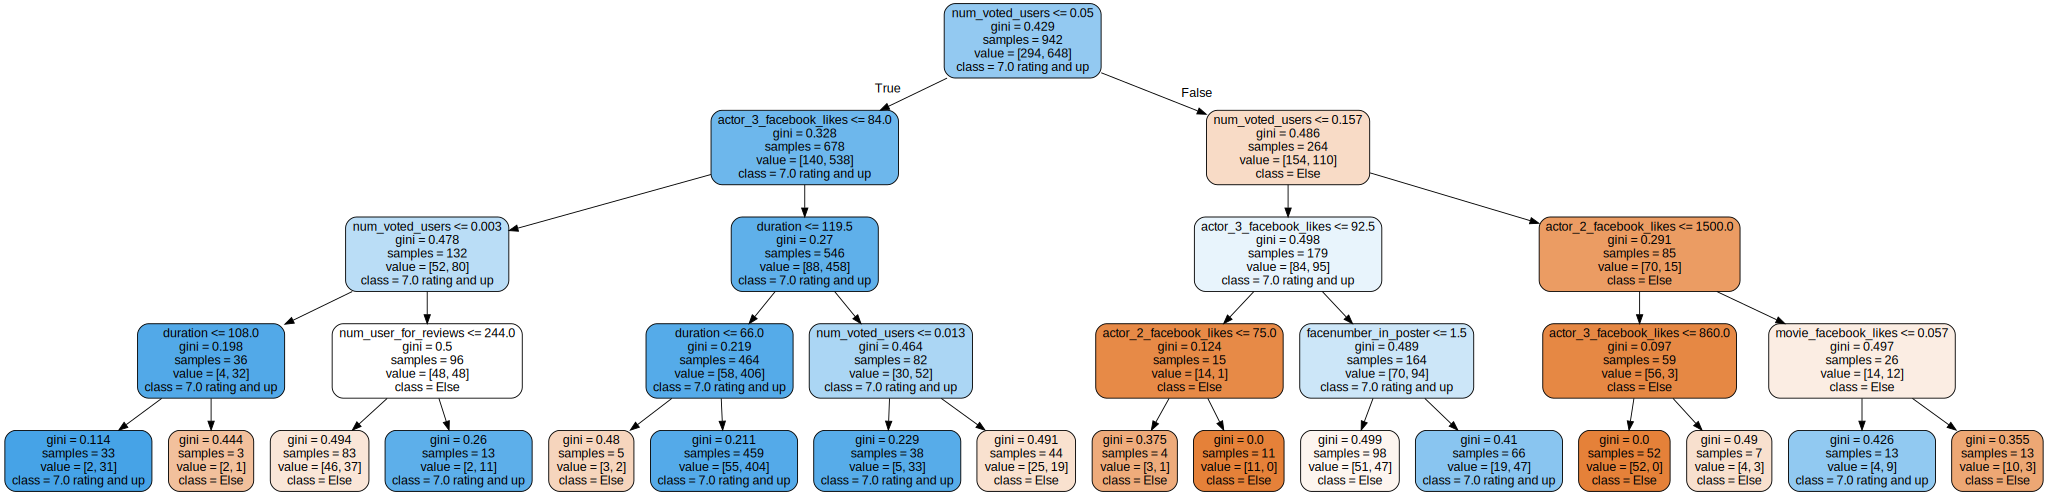

In [1536]:
#13 print model 
graph

In [1537]:
#specific scores (roc_auc, balanced_accuracy)
model.cv_results_
model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc', 'split4_test_roc_auc', 'split5_test_roc_auc', 'split6_test_roc_auc', 'split7_test_roc_auc', 'split8_test_roc_auc', 'split9_test_roc_auc', 'split10_test_roc_auc', 'split11_test_roc_auc', 'split12_test_roc_auc', 'split13_test_roc_auc', 'split14_test_roc_auc', 'split15_test_roc_auc', 'split16_test_roc_auc', 'split17_test_roc_auc', 'split18_test_roc_auc', 'split19_test_roc_auc', 'split20_test_roc_auc', 'split21_test_roc_auc', 'split22_test_roc_auc', 'split23_test_roc_auc', 'split24_test_roc_auc', 'split25_test_roc_auc', 'split26_test_roc_auc', 'split27_test_roc_auc', 'split28_test_roc_auc', 'split29_test_roc_auc', 'split30_test_roc_auc', 'split31_test_roc_auc', 'split32_test_roc_auc', 'split33_test_roc_auc', 'split34_test_roc_auc', 'split35_test_roc_auc', 'split36_test_roc_auc', 'split37_tes

In [1538]:
#scores
auc = model.cv_results_['mean_test_roc_auc']
bal_acc= model.cv_results_['mean_test_balanced_accuracy']

SDauc = model.cv_results_['std_test_roc_auc']
SDbal_acc= model.cv_results_['std_test_balanced_accuracy']

In [1539]:
#parameter
depth= np.unique(model.cv_results_['param_max_depth']).data

In [1540]:
#dataframe 
final_model = pd.DataFrame(list(zip(depth, auc, bal_acc,SDauc,SDbal_acc)),
               columns =['depth','auc','bal_acc','aucSD','bal_accSD'])

final_model

,depth,auc,bal_acc,aucSD,bal_accSD
0,1,0.650587,0.650587,0.047630,0.047630
1,2,0.693304,0.608605,0.046475,0.036873
2,3,0.720676,0.627308,0.051525,0.045524
3,4,0.728122,0.656229,0.045578,0.047559
4,5,0.712610,0.647990,0.054578,0.050899
5,6,0.692405,0.655250,0.059142,0.054844
6,7,0.676054,0.649646,0.060296,0.048541
7,8,0.646943,0.645845,0.067387,0.045618
8,9,0.634870,0.645181,0.069179,0.050022
9,10,0.631072,0.643537,0.063166,0.047313


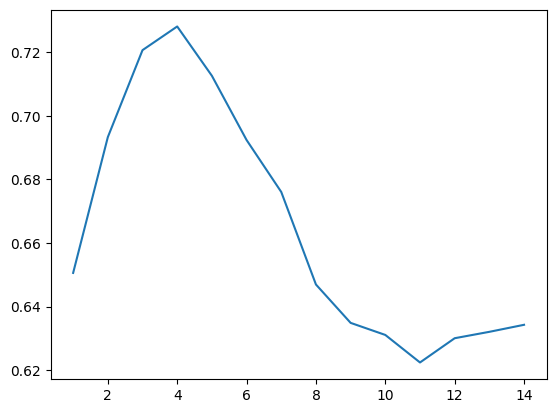

In [1541]:
plt.plot(final_model.depth,final_model.auc)

In [1542]:
#14 model performance 

# at depth value = 4, the auc = 0.728122 meaning that the model is able to distinguish betweeen classes (movies with a 7.0 rating or higher or other) moderately well, with auc = 0.5 indicating the model performs no better than random chance 

# at depth value = 4, the balanced accuracy = 0.656229 meaning that the model performs better than random chance at 0.5, but has the potential for improvement regarding both sensivity and specificity

# at depth value = 4, AUC standard deviation = 0.045578, meaning AUC scores across different cross validation folds are relatively consistent; this score is small therefore the AUC scores from different cross validation folds are all close to the average AUC

# at depth value = 4, balanced accuracy standard deviation = 0.047559, meaning balanced accuracy scores across different cross validation folds are relatively consistent; this score is small therefore balanced accuracy scores from different cross validation folds are all close to the average balanced accuracy 

In [1503]:
#15 which variable is contributing the most

# num_voted_users is contributing the most as the variable in the parent node of the decision tree, num_voted_users is the most influential in initiating data splitting

# other influential variables are duration and actor_3_facebook_likes

num_voted_users: 0.30039082538213413
duration: 0.15463059061468157
actor_3_facebook_likes: 0.12372457208578821
num_user_for_reviews: 0.110026379673424
actor_2_facebook_likes: 0.10741197982936297
movie_facebook_likes: 0.08990071872344796
cast_total_facebook_likes: 0.048142730266496944
facenumber_in_poster: 0.03679660242598972
actor_1_facebook_likes: 0.028975600998674522


In [1543]:
#16 pred method on test data classification report 
y_pred = model.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)

# precision = the ratio of true positive predictions to the total number of positive predictions made by the model
# recall =  the ratio of true positive predictions to the total number of actual positive instances
# mean of precision and recall

                   precision    recall  f1-score   support

7.0 rating and up       0.52      0.64      0.57       589
             Else       0.82      0.73      0.77      1297

         accuracy                           0.70      1886
        macro avg       0.67      0.68      0.67      1886
     weighted avg       0.72      0.70      0.71      1886



In [1544]:
#17 model performance on test data 

# the model performed better on the Else class than the 7.0 rating and up class with higher precision, recall and f1-scores

# precision and F1 scores were relatively lower for the 7.0 rating and up class than the Else class, the model could be improved to better capture true prositive instances for the 7.0 rating and up class 

# the accuracy score is 0.7 or 70%, meaning the model performs better than random chance, random chance accuracy = 0.50

In [1545]:
#18 confusion matrix test data 
y_pred = model.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[377, 212],
       [352, 945]], dtype=int64)

In [1547]:
#19 top 3 movies based on the test set 

# the decision tree indicates that the most influential variables in the model are num_voted_users, duration, actor_3_facebook_likes

# the top three movies based on the test set should have the values amongst these variables 

# the top three movies based on the test set are The Shawshank Redemption, The Dark Knight, and Fight Club 


movie_metadata_top_movies= movie_metadata.sort_values(by=['num_voted_users', 'duration'], ascending=[False, False])
movie_metadata_top_movies['movie_title']

1937          The Shawshank Redemption 
66                     The Dark Knight 
97                           Inception 
683                         Fight Club 
3355                      Pulp Fiction 
                     ...               
4716           Light from the Darkroom 
4880                         UnDivided 
279            10,000 B.C.             
4958    Over the Hill to the Poorhouse 
4702      The Hadza: Last of the First 
Name: movie_title, Length: 5043, dtype: object

In [1549]:
#19 top 3 movies based on the test set

x_test= x_test.sort_values(by=['num_voted_users', 'duration'], ascending=[False, False])
x_test

,duration,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,actor_2_facebook_likes,movie_facebook_likes
1937,142.0,461.0,11000.0,1.000000e+00,0.020549,0.0,4144.0,745.0,0.309456
66,152.0,11000.0,23000.0,9.919545e-01,0.088015,0.0,4667.0,13000.0,0.106017
683,151.0,637.0,11000.0,7.974250e-01,0.020113,2.0,2968.0,783.0,0.137536
3355,178.0,857.0,13000.0,7.839432e-01,0.025211,1.0,2195.0,902.0,0.128940
3466,175.0,3000.0,14000.0,6.839822e-01,0.042821,1.0,2238.0,10000.0,0.123209
...,...,...,...,...,...,...,...,...,...
5036,84.0,2.0,45.0,1.834581e-05,0.000142,0.0,1.0,44.0,0.000011
4378,112.0,11.0,86.0,1.361141e-05,0.000212,0.0,1.0,42.0,0.000209
4883,108.0,3.0,288.0,1.183601e-05,0.000589,6.0,1.0,96.0,0.000203
4716,90.0,271.0,595.0,5.918004e-07,0.002671,0.0,1.0,412.0,0.000026


In [1501]:
#summarization and recommendations 

# the model works relatively well, with an accuracy of 70% on the test data and AUC and balanced accuracy scores conisistent across different cross validation folds on training data 

# the model could be improved to better capture true prositive instances for the 7.0 rating and up class, it is possible that since there are more instances of the Else class (1297) than the 7.0 rating and up class (589) there may be class imbalance that is contributing to the precision, recall, and F1 scores on the test data 

# Threshold can be adjusted on the model to increase sensitivity, potentially classifying more true positive instances
# Class imbalance can be addressed through hyper parameter tuning for max_depth, min_samples_split, and min_samples_leaf, for example decreasing min_samples_split might create a more complex tree capturing more specific patterns in the data 

# Future use of the model could include increasing categories for classification within imdb scores, with classes such as: rating 0-3.0, rating 3.0-5.0, rating 5.0-7.0, and rating, 7.0-10, to split the Else class into smaller groups 